In [29]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [31]:
!kaggle datasets download -d pybear/cats-vs-dogs

cats-vs-dogs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cats-vs-dogs.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [35]:
Batch_size = 32
Image_size = (180,180)

In [36]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'PetImages',
    subset = 'training',
    validation_split = 0.2,
    seed = 1337,
    image_size = Image_size,
    batch_size = Batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


In [37]:
validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'PetImages',
    subset = 'validation',
    validation_split = 0.2,
    seed = 1337,
    image_size = Image_size,
    batch_size = Batch_size
)

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['Cat', 'Dog']


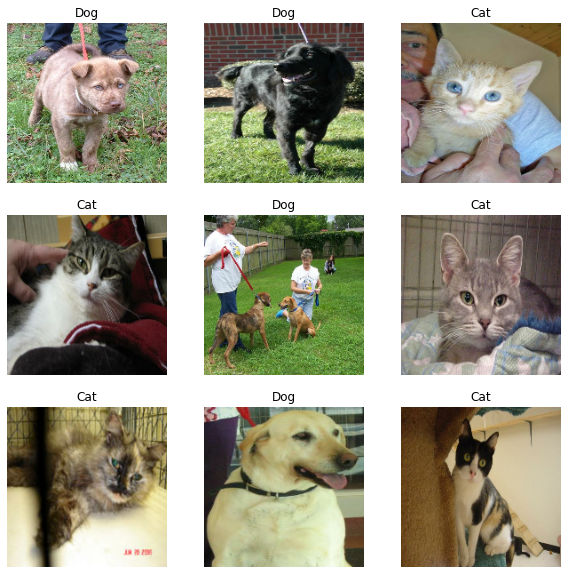

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data Augmentation

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal', input_shape=(180, 180, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

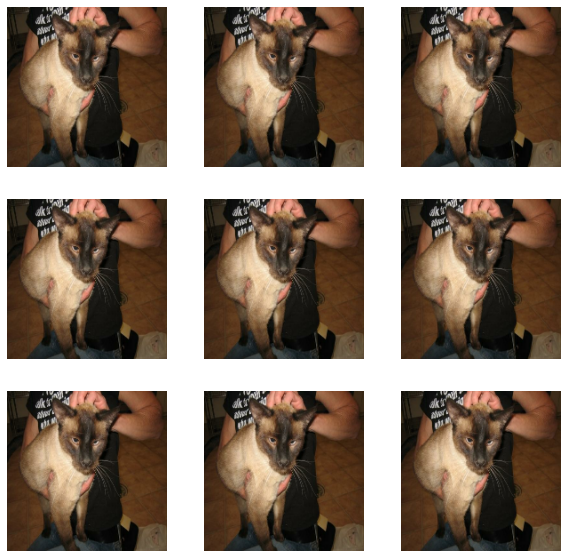

In [41]:
plt.figure(figsize = (10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [42]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [43]:
num_classes = len(class_names)

In [44]:
model = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=(180, 180, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, name='outputs')
    ]
)

In [45]:
model.compile(optimizer = 'adam', loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [47]:
epochs = 10

history = model.fit(train_ds, validation_data = validation_ds, epochs = epochs)

Epoch 1/10
586/586 [==============================] - 46s 77ms/step - loss: 0.5972 - accuracy: 0.6754 - val_loss: 0.5441 - val_accuracy: 0.7290
Epoch 2/10
586/586 [==============================] - 34s 58ms/step - loss: 0.4826 - accuracy: 0.7655 - val_loss: 0.4429 - val_accuracy: 0.7956
Epoch 3/10
586/586 [==============================] - 36s 61ms/step - loss: 0.4034 - accuracy: 0.8148 - val_loss: 0.4779 - val_accuracy: 0.7806
Epoch 4/10
586/586 [==============================] - 35s 58ms/step - loss: 0.3179 - accuracy: 0.8612 - val_loss: 0.4973 - val_accuracy: 0.7984
Epoch 5/10
586/586 [==============================] - 35s 59ms/step - loss: 0.2291 - accuracy: 0.9045 - val_loss: 0.6522 - val_accuracy: 0.8037
Epoch 6/10
586/586 [==============================] - 34s 57ms/step - loss: 0.1532 - accuracy: 0.9396 - val_loss: 0.7166 - val_accuracy: 0.8054
Epoch 7/10
586/586 [==============================] - 34s 58ms/step - loss: 0.1111 - accuracy: 0.9573 - val_loss: 0.6628 - val_accuracy:

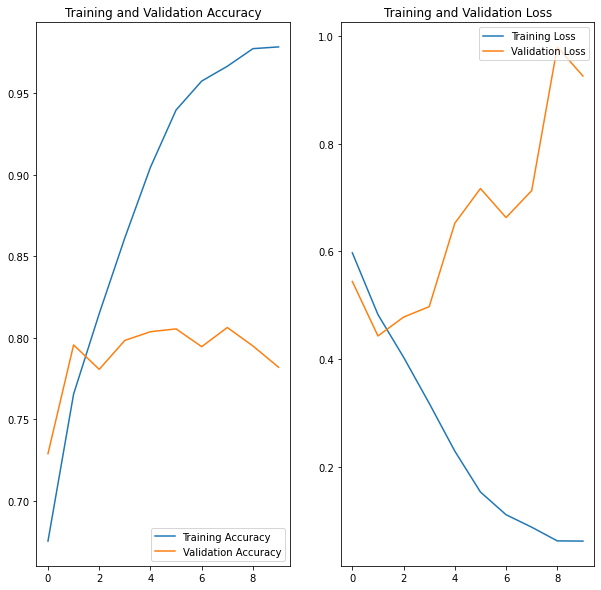

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label = 'Training Accuracy')
plt.plot(epoch_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label = 'Training Loss')
plt.plot(epoch_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [52]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data = validation_ds,
  epochs = epochs
)

Epoch 1/15
586/586 [==============================] - 37s 61ms/step - loss: 0.6284 - accuracy: 0.6485 - val_loss: 0.5470 - val_accuracy: 0.7247
Epoch 2/15
586/586 [==============================] - 35s 59ms/step - loss: 0.5475 - accuracy: 0.7214 - val_loss: 0.5263 - val_accuracy: 0.7377
Epoch 3/15
586/586 [==============================] - 35s 59ms/step - loss: 0.5000 - accuracy: 0.7558 - val_loss: 0.4987 - val_accuracy: 0.7493
Epoch 4/15
586/586 [==============================] - 37s 62ms/step - loss: 0.4701 - accuracy: 0.7757 - val_loss: 0.4760 - val_accuracy: 0.7826
Epoch 5/15
586/586 [==============================] - 36s 60ms/step - loss: 0.4373 - accuracy: 0.7938 - val_loss: 0.4078 - val_accuracy: 0.8174
Epoch 6/15
586/586 [==============================] - 36s 60ms/step - loss: 0.4178 - accuracy: 0.8075 - val_loss: 0.3985 - val_accuracy: 0.8208
Epoch 7/15
586/586 [==============================] - 36s 60ms/step - loss: 0.4070 - accuracy: 0.8133 - val_loss: 0.3969 - val_accuracy:

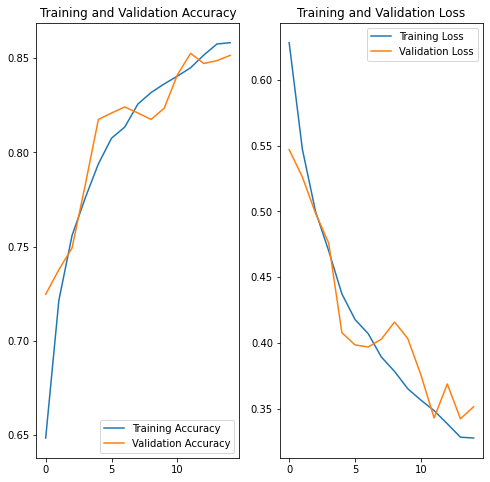

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
image_url = "https://hips.hearstapps.com/vidthumb/images/gettyimages-155696335-1619709287.jpg"
image_path = keras.utils.get_file('gettyimages-155696335-1619709287', origin = image_url)

img = tf.keras.utils.load_img(
    image_path, target_size=(180, 180)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

90112/78035 [==================================] - 0s 0us/step
This image most likely belongs to Dog with a 99.63 percent confidence.
